In [2]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [2]:
!cp /mydrive/music\ project/X_spec.pickle ./
!cp /mydrive/music\ project/y_spec.pickle ./

In [4]:
#LOADING DATA
import pickle 
pickle_off = open("X_spec.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [5]:
# For visual
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from IPython import display
import tensorflow as tf

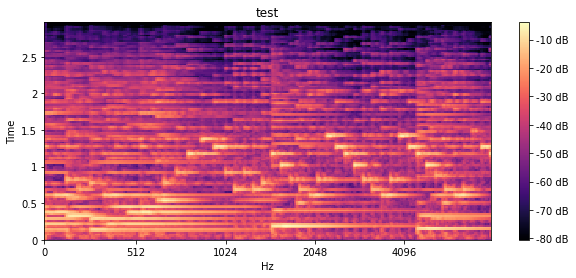

In [6]:
  genre_name = 'test'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(X_spec[5,:256,:].T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()

In [38]:
import scipy
from scipy.io.wavfile import write
import numpy as np


sr=22050
t = X_spec[5,:256,:]
audio_path = '/content/audio/test3.wav'
wav = librosa.db_to_power(t.T, ref=1.0)
wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
wav *= 32767 / max (0.01, np.max(np.abs(wav)))
write (audio_path, sr, wav.astype(np.int16))
#write (audio_path, sr, wav.astype(np.float32))

In [7]:
#Normalize

X_spect = (X_spec.astype('float32') + 100) /116
y_spect = (y_spec.astype('float32') + 100) /116

In [8]:
# train and split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_spect, y_spect, test_size=0.1, random_state=42)

In [9]:
import numpy as np

print(X_train.shape)
print(X_test.shape)
train = np.array([X_train, y_train])
test = np.array([X_test, y_test])
print(train.shape)
print(test.shape)
train = train.reshape(2,1287,300,128,1)
test = test.reshape(2,144,300,128,1)
print(train.shape)
print(test.shape)

(1287, 300, 128)
(144, 300, 128)
(2, 1287, 300, 128)
(2, 144, 300, 128)
(2, 1287, 300, 128, 1)
(2, 144, 300, 128, 1)


In [85]:
X_ = (X_spec.astype('float32')+50) /60
print(X_.max(), X_spec.min(), X_spect.min(), train.min())

1.0723438 -100.0 -1.7241379 -1.7241379


In [10]:
train_size = 1287
batch_size = 32
test_size = 144

#train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 #.shuffle(train_size).batch(batch_size))
train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .batch(batch_size))

In [11]:
def normalize_test(input_image, input_mask):
    input_image = input_image[:,:256,:,:]
    input_mask = input_mask[:,:256,:,:]
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

train_dataset = train_dataset.map(load_image_test)

In [12]:
def normalize_test(input_image, input_mask):
    input_image = input_image[:,:256,:,:]
    input_mask = input_mask[:,:256,:,:]
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

test_dataset = test_dataset.map(load_image_test)

In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [14]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(train[1,1], 0))
print (down_result.shape)

(1, 150, 64, 3)


In [15]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [16]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 300, 128, 3)


In [17]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 128, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    #downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
generator = Generator()

In [54]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


(256, 128)


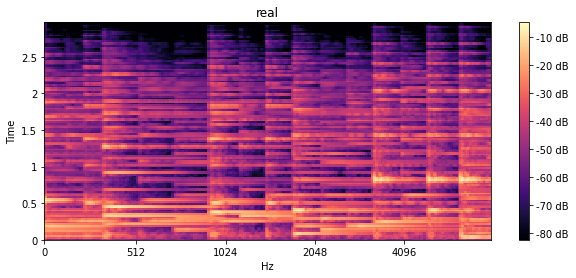

(1, 256, 128, 3)
(1, 256, 128)


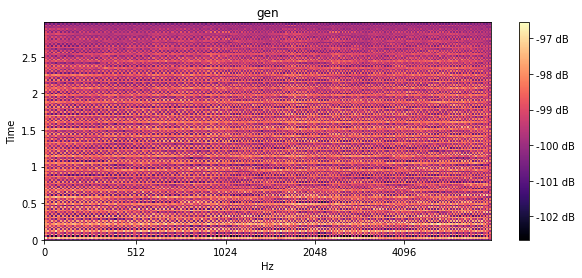

In [27]:
import matplotlib.pyplot as plt


for i in train_dataset.take(1):
  j = np.array(i) 
  one = (j[0,1,:,:,1] * 116) -100
  print(one.shape)

  genre_name = 'real'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(one.T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()

  gen_output = generator(j[0,:1,:256,:,:], training=False)
  print(gen_output.shape)
  tt = (gen_output[:,:,:,1] * 116 ) -100
  print(tt.shape)

  tt = np.array(tt).reshape(256,128)
  genre_name = 'gen'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(tt.T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()
  #plt.imshow(gen_output[0, ...])
  break


In [28]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [29]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)